## Customer segmentation clustering

In [87]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("C:/Users/hp/Downloads/Customers.csv")
transactions = pd.read_csv("C:/Users/hp/Downloads/Transactions.csv")

In [89]:
# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Calculate customer tenure in days
customers['CustomerTenure'] = (customers['SignupDate'] - customers['SignupDate'].min()).dt.days

# Aggregate transaction data at the customer level
transaction_aggregates = transactions.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    PurchaseCount=('TransactionID', 'count'),
    AveragePurchaseValue=('TotalValue', 'mean'),
    TotalQuantity=('Quantity', 'sum')
).reset_index()

# Merge customer and transaction data
customer_data = pd.merge(customers, transaction_aggregates, on='CustomerID', how='left')

# Fill missing values for customers without transactions
customer_data.fillna({'TotalSpent': 0, 'PurchaseCount': 0, 'AveragePurchaseValue': 0, 'TotalQuantity': 0}, inplace=True)

In [91]:
# Preprocessing: Scale numeric features and encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['CustomerTenure', 'TotalSpent', 'PurchaseCount', 'AveragePurchaseValue', 'TotalQuantity']),
        ('cat', OneHotEncoder(), ['Region'])
    ]
)

# Apply preprocessing to the data
processed_features = preprocessor.fit_transform(customer_data)

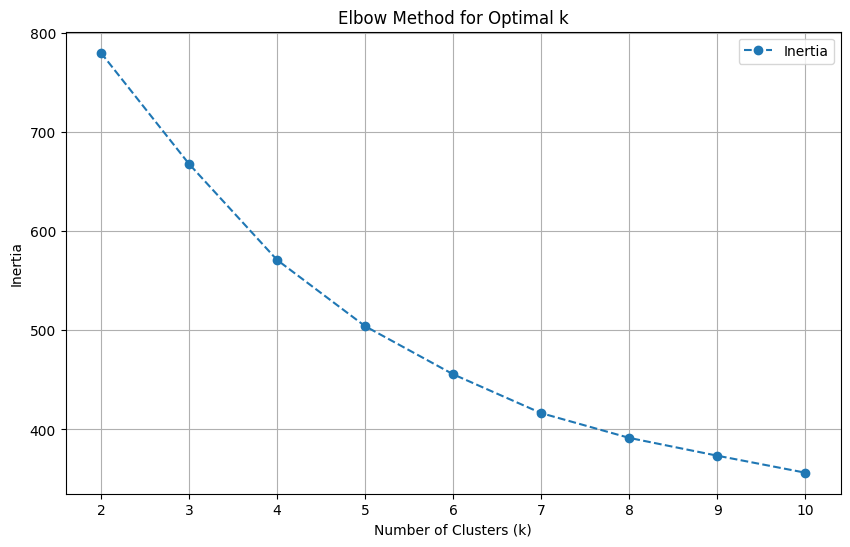

In [93]:
# Determine Optimal Clusters
inertia = []
db_indices = []
sil_scores = []
cluster_range = range(2, 11)  # Explore cluster counts from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(processed_features)
    inertia.append(kmeans.inertia_)
    db_indices.append(davies_bouldin_score(processed_features, kmeans_labels))
    sil_scores.append(silhouette_score(processed_features, kmeans_labels))

# Plot Elbow Curve for Inertia
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--', label='Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.grid()
plt.show()

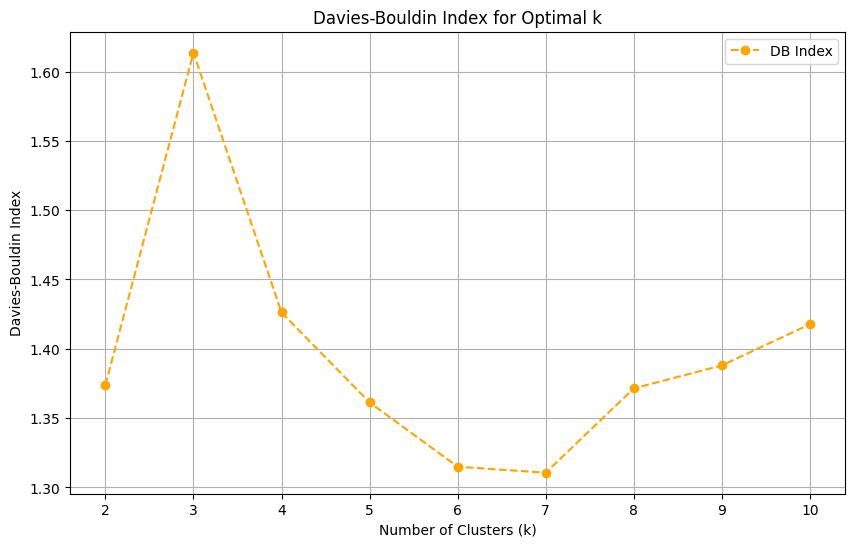

In [94]:
# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_indices, marker='o', linestyle='--', color='orange', label='DB Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal k')
plt.legend()
plt.grid()
plt.show()

Optimal Number of Clusters: 7
Silhouette Score: 0.21861623372889716
Davies-Bouldin Index (DBI): 1.310604773384916


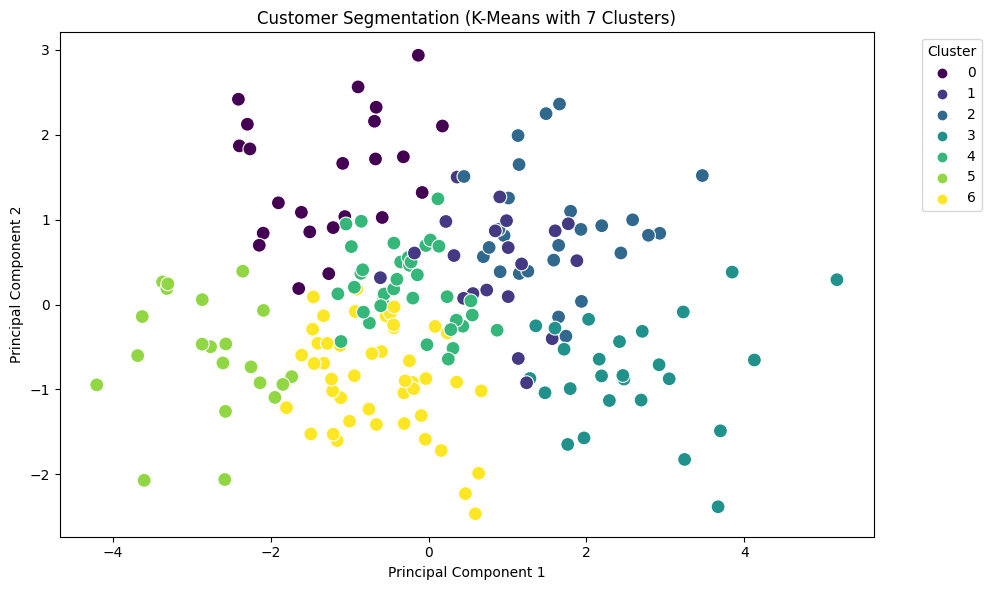

In [97]:
# Find optimal number of clusters based on Davies-Bouldin Index
optimal_clusters = db_indices.index(min(db_indices)) + 2
print(f"Optimal Number of Clusters: {optimal_clusters}")

# Perform Clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(processed_features)
customer_data['Cluster'] = kmeans_labels

# Calculate clustering metrics
silhouette = silhouette_score(processed_features, kmeans_labels)
db_index = davies_bouldin_score(processed_features, kmeans_labels)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index (DBI): {db_index}")

# PCA for Visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(processed_features)

# Visualize Clusters using PCA-reduced data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=kmeans_labels,
    palette='viridis',
    s=100
)
plt.title(f"Customer Segmentation (K-Means with {optimal_clusters} Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

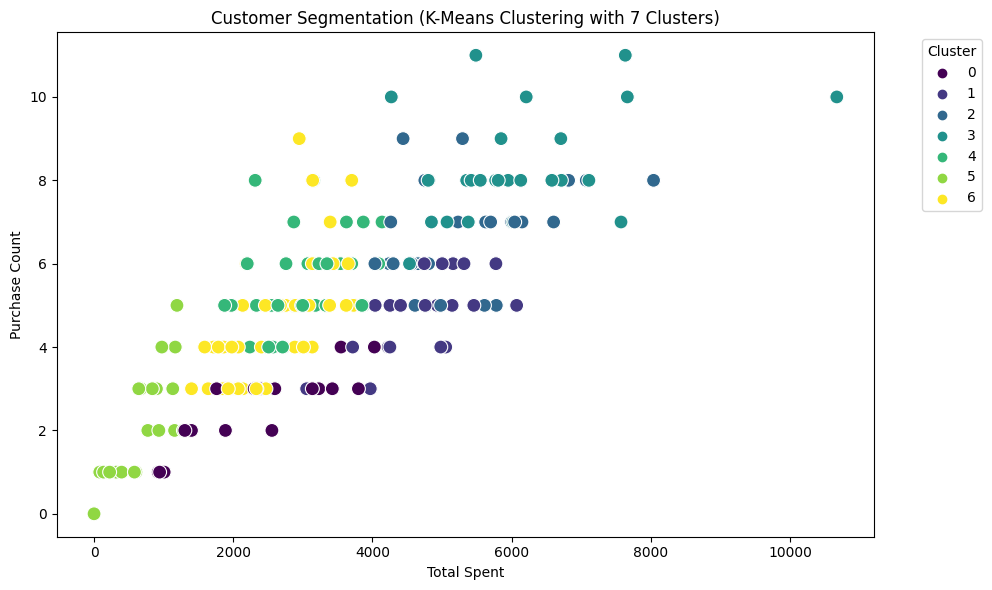

In [99]:
# Scatter plot for TotalSpent vs PurchaseCount
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data['TotalSpent'], 
    y=customer_data['PurchaseCount'], 
    hue=customer_data['Cluster'], 
    palette='viridis', 
    s=100
)
plt.title(f"Customer Segmentation (K-Means Clustering with {optimal_clusters} Clusters)")
plt.xlabel("Total Spent")
plt.ylabel("Purchase Count")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

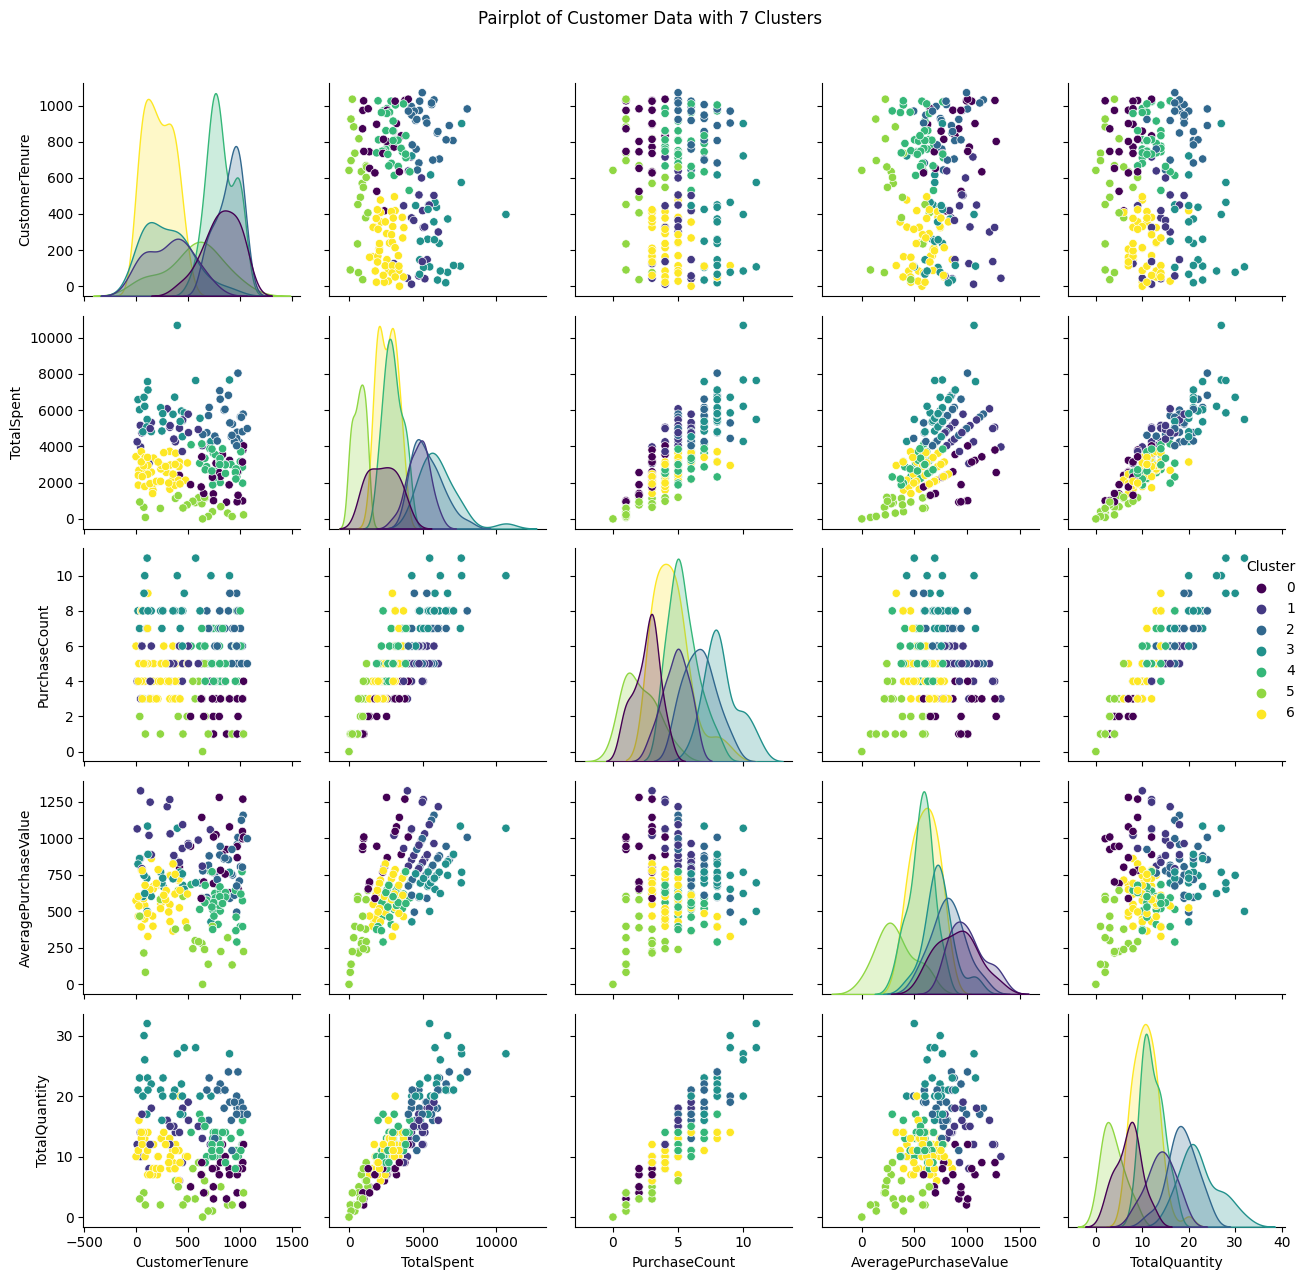


--- End of Comprehensive Customer Segmentation Analysis ---


In [101]:
# Pairplot for multi-dimensional feature relationships
sns.pairplot(customer_data, hue='Cluster', vars=['CustomerTenure', 'TotalSpent', 'PurchaseCount', 'AveragePurchaseValue', 'TotalQuantity'], palette='viridis')
plt.suptitle(f"Pairplot of Customer Data with {optimal_clusters} Clusters", y=1.02)
plt.tight_layout()
plt.show()

print("\n--- End of Comprehensive Customer Segmentation Analysis ---")